### データセットをトレーニングデータセットとテストデータセットに分割する

* Wineデータセットを用い、前処理を行った後次元数を減らすための特徴選択の手法を見ていく。
* wineデータセットのクラスは1,2,3の3種類。これは3種類の葡萄を表している。

In [2]:
import pandas as pd
import numpy as np
df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data', header=None)
df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash', 'Alcalinity of ash', 'Magnesium', 'Total phenols', 'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins', 'color intensity', 'Hue', 'OD280/OD315 of diluted wines', 'Proline']
print('Class labels', np.unique(df_wine['Class label']))
df_wine.head()

Class labels [1 2 3]


,Class label,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [3]:
from sklearn.cross_validation import train_test_split
# X:特徴量 y: クラスラベル
X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

C:\Users\maeda\Miniconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### 特徴量の尺度を揃える

一般的な手法は__正規化(normalization)__と__標準化(standardization)__の２つ。

#### 正規化

特徴量を[0,1]の範囲にスケーリングし直すこと。

$$ x_{norm}^{(i)} = \frac{x^{(i)} - x_{min}}{x_{max} - x_{min}} $$

In [4]:
from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()
X_train_norm = mms.fit_transform(X_train)
X_test_norm = mms.transform(X_test)
print('正規化前')
print(X_train[0])
print('正規化後')
print(X_train_norm[0])

正規化前
[  1.37100000e+01   1.86000000e+00   2.36000000e+00   1.66000000e+01
   1.01000000e+02   2.61000000e+00   2.88000000e+00   2.70000000e-01
   1.69000000e+00   3.80000000e+00   1.11000000e+00   4.00000000e+00
   1.03500000e+03]
正規化後
[ 0.72043011  0.20378151  0.53763441  0.30927835  0.33695652  0.54316547
  0.73700306  0.25        0.40189873  0.24068768  0.48717949  1.          0.5854251 ]


#### 標準化

平均値0, 標準偏差1となるように変換する。以下の点で正規化より優れている。

* 特徴量の列は正規分布に従うため、重みを学習しやすくなる
* 外れ値に関する有益な情報が維持されるため、外れ値の影響を受けにくい

$$ x_{std}^{(i)} = \frac{x^{(i)} - \mu_x}{\sigma_x} $$

* \\( \mu_x \\)：特徴量の列の平均値
* \\( \sigma_x \\)：対応する標準偏差

In [5]:
from sklearn.preprocessing import StandardScaler

stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.transform(X_test)

print('標準化前')
print(X_train[0])
print('標準化後')
print(X_train_std[0])

標準化前
[  1.37100000e+01   1.86000000e+00   2.36000000e+00   1.66000000e+01
   1.01000000e+02   2.61000000e+00   2.88000000e+00   2.70000000e-01
   1.69000000e+00   3.80000000e+00   1.11000000e+00   4.00000000e+00
   1.03500000e+03]
標準化後
[ 0.91083058 -0.46259897 -0.01142613 -0.82067872  0.06241693  0.58820446
  0.93565436 -0.7619138   0.13007174 -0.51238741  0.65706596  1.94354495
  0.93700997]


## 有益な特徴量の選択

汎化誤差を減らすための一般的な方法は以下のとおり

* 更に多くのトレーニングデータを集める
* 正則化を通じて複雑さにペナルティを課す
* パラメータの数が少ない、より単純なモデルを選択する
* データの次元の数を減らす

### L1正則化による疎な解

L2正則化は以下だった。

$$ L2:||w||_2^2 = \sum_{j=1}^m w^2_j $$


L2正則化は以下のとおり。

$$ L1:||w||_1 = \sum_{j=1}^m |w_j| $$

差は二乗和を絶対値の和に置き換えている。

* L1正則化によって返されるのは疎な特徴ベクトル
* 殆どの特徴量の重みは0
* 無関係な特徴量の個数が多い高次元データセットに対して特徴量を選択するのに有効

### なぜ特徴量を選択できる？

* L2正則化のペナルティは二乗和なので原点を中心とした円のようなものになる。
* L1正則化のペナルティは絶対値の和なので原点を中心としたひし形のようなものになる。

→ ひし形の頂点がコストの一番低いところになりやすい。

__頂点となる箇所はどちらかの重みがゼロで、どちらかが最大となる。__

In [6]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(penalty='l1', C=0.1)
lr.fit(X_train_std, y_train)
print('Training accuracy:', lr.score(X_train_std, y_train))
print('Test accuracy:', lr.score(X_test_std, y_test))
print('切片:', lr.intercept_)
print('重み係数:', lr.coef_)

Training accuracy: 0.983870967742
Test accuracy: 0.981481481481
切片: [-0.38381109 -0.15807604 -0.70040021]
重み係数: [[ 0.28017709  0.          0.         -0.02796546  0.          0.
   0.71007597  0.          0.          0.          0.          0.
   1.23635364]
 [-0.64398098 -0.06876215 -0.05721573  0.          0.          0.          0.
   0.          0.         -0.92673766  0.06017464  0.         -0.37104618]
 [ 0.          0.06147376  0.          0.          0.          0.
  -0.63652985  0.          0.          0.49833162 -0.35806622 -0.57075891
   0.        ]]


* 上記で切片が3つあるが、3種類のクラス(葡萄)を見分けるため、1つ目はクラス1対クラス2,3に適合するモデルの切片(2つ目以降同様)となっている。
* 重み係数も3×13の行列で、クラスごとに重みベクトルが含まれる。
* 総入力\\( z \\)は、各重みに対して特徴量をかける

$$ z = w_1x_1 + ... + w_mx_m + b = \sum_{j=1}^m x_jw_j + b = {\boldsymbol w^Tx} + b  $$

L1正則化により殆どの重みが0となったため、無関係な特徴量に対しても頑健なモデルになった。

以下は正則化パス（正則化の強さに対する特徴量の重み係数）のグラフ。

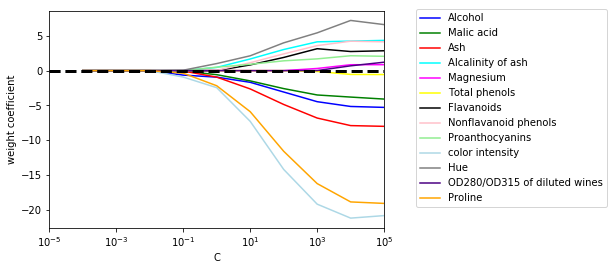

In [8]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = plt.subplot(111)
    
colors = ['blue', 'green', 'red', 'cyan', 
          'magenta', 'yellow', 'black', 
          'pink', 'lightgreen', 'lightblue', 
          'gray', 'indigo', 'orange']

weights, params = [], []
for c in np.arange(-4., 6.):
    lr = LogisticRegression(penalty='l1', C=10.**c, random_state=0)
    lr.fit(X_train_std, y_train)
    weights.append(lr.coef_[1])
    params.append(10.**c)

weights = np.array(weights)

for column, color in zip(range(weights.shape[1]), colors):
    plt.plot(params, weights[:, column],
             label=df_wine.columns[column + 1],
             color=color)
plt.axhline(0, color='black', linestyle='--', linewidth=3)
plt.xlim([10**(-5), 10**5])
plt.ylabel('weight coefficient')
plt.xlabel('C')
plt.xscale('log')
plt.legend(loc='upper left')
ax.legend(loc='upper center', 
          bbox_to_anchor=(1.38, 1.03),
          ncol=1, fancybox=True)
# plt.savefig('./figures/l1_path.png', dpi=300)
plt.show()

### 逐次特徴選択アルゴリズム

* 特徴選択は次元削減法の一つ
* 逐次特徴選択は貪欲探索アルゴリズムの一つ
* 貪欲探索アルゴリズムは、d次元の特徴空間をk次元に削減するために使用される

#### 特徴選択の目的

* 関連データのみを計算することによる計算効率の改善
* 無関係なノイズを取り除くことによる汎化誤差の削減


#### 逐次後退選択(Sequential Backward Selection: SBS)

* 特徴量を逐次的に削除していく
* 削除する特徴量は評価関数\\( J \\)によって決め、性能の低下が最も少ない特徴量を削除する

ステップは以下の通り

1. アルゴリズムを\\( k=d \\)で初期化する。\\( d \\)は全体の特徴空間\\( X_d \\)の次元数を表す。
2. \\( J \\)の評価を最大化する特徴量\\( x^- \\)を決定する。\\( x \\)は\\( x \in X_k \\)である
$$ x^- = argmax J(X_k-x) $$
3. 特徴量の集合から特徴量\\( x^- \\)を削除する
$$ x_{k-1} = X_k - x^-;k := k-1 $$
4. \\( k \\)が目的とする特徴量の個数に等しくなれば終了する。そうでなければ、ステップ2に戻る。

In [16]:
from sklearn.base import clone
from itertools import combinations
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

class SBS():
    '''逐次後退選択を実行するクラス
    
    Parameters
    ---------
    estimator : 推定器
    k_features : 選択する特徴量の個数
    scoring : 特徴量を評価する指標
    test_size : テストデータの割合
    random_state : 乱数シード
    '''
    def __init__(self, estimator, k_features, scoring=accuracy_score,
                 test_size=0.25, random_state=1):
        self.scoring = scoring
        self.estimator = clone(estimator)
        self.k_features = k_features
        self.test_size = test_size
        self.random_state = random_state

    def fit(self, X, y):
        X_train, X_test, y_train, y_test = \
            train_test_split(X, y, test_size=self.test_size,
                             random_state=self.random_state)

        dim = X_train.shape[1]
        self.indices_ = tuple(range(dim))
        self.subsets_ = [self.indices_]
        # 全ての特徴量を用いてスコアを算出する
        score = self._calc_score(X_train, y_train,
                                 X_test, y_test, self.indices_)
        self.scores_ = [score]
        # 指定した特徴量の個数になるまで処理
        while dim > self.k_features:
            scores = []
            subsets = []
            # 特徴量の部分集合を表す列インデックスの組み合わせごとに反復
            for p in combinations(self.indices_, r=dim - 1):
                score = self._calc_score(X_train, y_train,
                                         X_test, y_test, p)
                scores.append(score)
                subsets.append(p)
            # 一番良いスコアを抽出
            best = np.argmax(scores)
            self.indices_ = subsets[best]
            self.subsets_.append(self.indices_)
            # 特徴量の個数を1つ減らす
            dim -= 1

            self.scores_.append(scores[best])
        self.k_score_ = self.scores_[-1]

        return self

    def transform(self, X):
        return X[:, self.indices_]

    def _calc_score(self, X_train, y_train, X_test, y_test, indices):
        self.estimator.fit(X_train[:, indices], y_train)
        y_pred = self.estimator.predict(X_test[:, indices])
        score = self.scoring(y_test, y_pred)
        return score

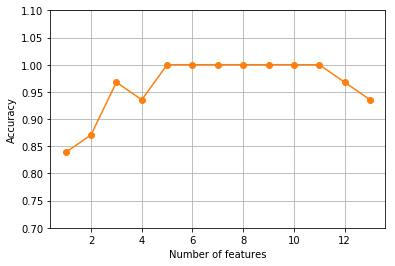

In [19]:
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt

knn = KNeighborsClassifier(n_neighbors=2)
sbs = SBS(knn, k_features=1)
sbs.fit(X_train_std, y_train)

# 近傍点の個数のリスト
k_feat = [len(k) for k in sbs.subsets_]
plt.plot(k_feat, sbs.scores_, marker='o')
plt.ylim([0.7, 1.1])
plt.ylabel('Accuracy')
plt.xlabel('Number of features')
plt.grid()
plt.show()

In [21]:
# 上記で100%の正答率を出した5つの特徴量を調べる
k5 = list(sbs.subsets_[8])
print(df_wine.columns[1:][k5])

Index(['Alcohol', 'Malic acid', 'Alcalinity of ash', 'Hue', 'Proline'], dtype='object')


In [24]:
# 特徴量の削減の様子
sbs.subsets_

[(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12),
 (0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12),
 (0, 1, 2, 3, 6, 7, 8, 9, 10, 11, 12),
 (0, 1, 2, 3, 6, 7, 8, 9, 10, 12),
 (0, 1, 2, 3, 6, 7, 8, 10, 12),
 (0, 1, 2, 3, 6, 8, 10, 12),
 (0, 1, 3, 6, 8, 10, 12),
 (0, 1, 3, 6, 10, 12),
 (0, 1, 3, 10, 12),
 (0, 1, 10, 12),
 (0, 1, 10),
 (0, 10),
 (0,)]

In [26]:
# 全特徴量を使用した場合
knn.fit(X_train_std, y_train)
print('Training accuracy:', knn.score(X_train_std, y_train))
print('Test accuracy:', knn.score(X_test_std, y_test))

Training accuracy: 0.983870967742
Test accuracy: 0.944444444444


In [28]:
# 5角特徴量を使用した場合
knn.fit(X_train_std[:, k5], y_train)
print('Training accuracy:', knn.score(X_train_std[:, k5], y_train))
print('Test accuracy:', knn.score(X_test_std[:, k5], y_test))

Training accuracy: 0.959677419355
Test accuracy: 0.962962962963
